# Machine learning program "Median House Value"


In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import time
import numpy as np
import tqdm

print("Tensorflow version: "+tf.__version__)

2022-10-21 10:50:59.720448: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Tensorflow version: 2.10.0


## Datasets

In [2]:
try:
    # Google file system
    from google.colab import drive
    drive.mount('/GoogleDrive', force_remount=True)

    ATT_FILE =   "/GoogleDrive/My Drive/Colab Notebooks/Datasets/MedianHouseValuePreparedCleanAttributes.csv"
    LABEL_FILE = "/GoogleDrive/My Drive/Colab Notebooks/Datasets/MedianHouseValueOneHotEncodedClasses.csv"
except ImportError:
    ATT_FILE = "MedianHouseValuePreparedCleanAttributes.csv"
    LABEL_FILE = "MedianHouseValueOneHotEncodedClasses.csv"

attributes = pd.read_csv(ATT_FILE)
label =      pd.read_csv(LABEL_FILE)

In [3]:
TRAIN_RATIO = 0.8

n_instances = attributes.shape[0]
n_train = int(n_instances*TRAIN_RATIO)
n_dev = int((n_instances - n_train)/2)

x_train = attributes.values[:n_train]
t_train = label.values[:n_train]
x_dev =   attributes.values[n_train:n_train + n_dev]
t_dev =   label.values[n_train:n_train + n_dev]

INPUTS =  x_train.shape[1]
OUTPUTS = t_train.shape[1]

NUM_TRAINING_EXAMPLES = int(round(x_train.shape[0]/1))
NUM_DEV_EXAMPLES =      int(round(x_dev.shape[0]/1))

print ("Number of training examples: ", NUM_TRAINING_EXAMPLES)
print ("Number of examples for development test: ", NUM_DEV_EXAMPLES)

Number of training examples:  16342
Number of examples for development test:  2043


## Model


In [4]:
n_neurons_per_hidden_layer = [500, 250, 75, 25]
learning_rate = 0.1

In [5]:
model = keras.Sequential(name="my_model")

model.add(keras.layers.InputLayer(input_shape=(INPUTS,)))
for neurons in n_neurons_per_hidden_layer:
  model.add(keras.layers.Dense(neurons, activation="relu"))
model.add(keras.layers.Dense(OUTPUTS, activation="softmax"))

2022-10-21 10:51:01.458947: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-21 10:51:01.459561: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [6]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
              metrics=["categorical_accuracy"])


## Training

In [7]:
n_epochs = 1000
batch_size = 512

In [8]:
from tqdm.keras import TqdmCallback

class RecordTime(TqdmCallback):
    def __init__(self):
        super().__init__()
        self.start_time = None
        self.end_time = None

    @property
    def total_time(self):
        return self.end_time - self.start_time

    @property
    def total_time_str(self):
        s = round(self.total_time)

        m, s = divmod(s, 60)
        h, m = divmod(m, 60)

        return f'{h:d}h {m:d}m {s:d}s'

    def on_train_begin(self, *args):
        super().on_train_begin(*args)
        self.start_time = time.perf_counter()
    
    def on_train_end(self, *args):
        self.end_time = time.perf_counter()
        super().on_train_begin(*args)
        print(f"Train took {self.total_time_str}")


In [9]:
rt = RecordTime()

history = model.fit(x_train, t_train, 
                    batch_size = batch_size, 
                    epochs=n_epochs, 
                    verbose = 0, 
                    validation_data = (x_dev, t_dev),
                    callbacks=[rt]
                    )

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Train took 0h 12m 26s


## Results

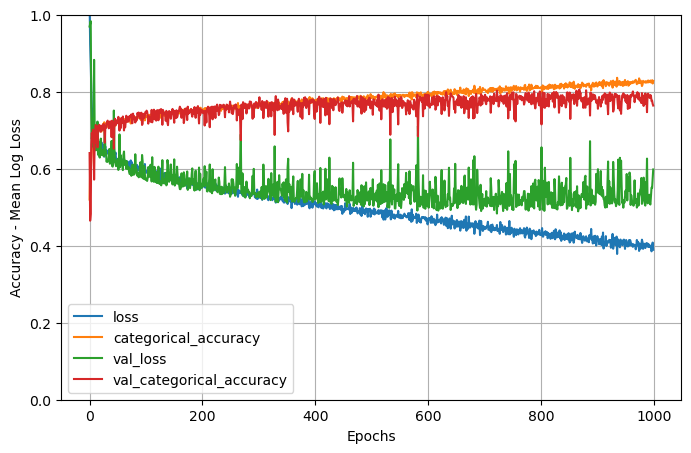

In [10]:
results = pd.DataFrame(history.history)
results.plot(figsize = (8, 5))
plt.grid(True)
plt.xlabel ("Epochs")
plt.ylabel ("Accuracy - Mean Log Loss")
plt.gca().set_ylim(0, 1) # set the vertical range to [0,1]
plt.show()

### Exercise 1.

Determine the following values: train error, test error (using dev set), bias, variance and training time. Repeat the execution at least
three times. Consider 5% as Bayesian error (human error).

In [11]:
human_error = 0.05
training_error = 1 - results.categorical_accuracy.values[-1]
test_error = 1 - results.val_categorical_accuracy.values[-1]

print(f"Error (human): {human_error*100:.0f}%")
print(f"Error (training): {training_error*100:.2f}%")
print(f"Error (test): {test_error*100:.2f}%")
print(f"Bias: {(training_error - human_error)*100:.2f}%")
print(f"Variance: {(training_error - test_error)*100:.2f}%")
print("Total time:", rt.total_time_str)

Error (human): 5%
Error (training): 17.18%
Error (test): 23.59%
Bias: 12.18%
Variance: -6.41%
Total time: 0h 12m 26s


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4f17627b-1a01-413e-b5c6-316bf312de2c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>